In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import defaultdict

plt.style.use('seaborn-v0_8-paper')
sns.set_palette("muted")

In [2]:
results_df = pd.read_csv("../results/c-terminal-extension/final_candidates.tsv", sep='\t')

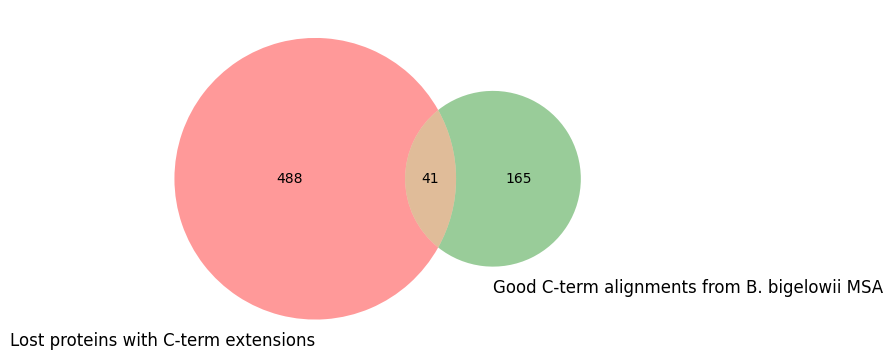

In [3]:
extension_ids = set(results_df['qseqid'])

good_c_term = SeqIO.parse('../data/good-c-term-full.fasta', 'fasta')
good_c_term_ids = set([seq.id for seq in good_c_term])

import matplotlib_venn

matplotlib_venn.venn2([extension_ids, good_c_term_ids], ('Lost proteins with C-term extensions', 'Good C-term alignments from B. bigelowii MSA'))

In [4]:
bb_seqs = { s.id: s for s in SeqIO.parse('../data/ADK1075_proteomics_DB_2.fasta', 'fasta') }
bb_seq_ids = set(bb_seqs.keys())

# Filter out good c-term alignments and extensions that are not in the B. bigelowii MSA
bb_no_extension_ids = bb_seq_ids - extension_ids - good_c_term_ids

bb_no_extension_seqs = [bb_seqs[i] for i in bb_no_extension_ids]

# Write the sequences to a fasta file
SeqIO.write(bb_no_extension_seqs, '../data/bb_no_extension_seqs.fasta', 'fasta')



43669

In [5]:
from scipy.stats import hypergeom
import numpy as np

# Known values
total_proteins = 44363  # Total proteins in B. bigelowii genome
extension_hits = 529    # Number of proteins found by extension search
msa_hits = 165         # Number of proteins found by MSA
observed_overlap = 41   # Number of proteins found by both methods

# Calculate probability using hypergeometric distribution
# Parameters:
# M = total population (total proteins)
# n = number of success states in population (extension hits)
# N = number of draws (MSA hits)
# k = number of observed successes (overlap)

# Probability of getting exactly this overlap
exact_prob = hypergeom.pmf(k=observed_overlap, M=total_proteins, n=extension_hits, N=msa_hits)

# Probability of getting this overlap or greater by chance
pvalue = hypergeom.sf(k=observed_overlap-1, M=total_proteins, n=extension_hits, N=msa_hits)

# Calculate expected overlap by chance
expected_overlap = (extension_hits * msa_hits) / total_proteins

print(f"Analysis of overlap significance:")
print(f"Expected overlap by chance: {expected_overlap:.2f} proteins")
print(f"Observed overlap: {observed_overlap} proteins")
print(f"P-value (probability of this overlap or greater by chance): {pvalue:.2e}")
print(f"Probability of exactly this overlap: {exact_prob:.2e}")
print(f"Enrichment factor: {observed_overlap/expected_overlap:.2f}x")

Analysis of overlap significance:
Expected overlap by chance: 1.97 proteins
Observed overlap: 41 proteins
P-value (probability of this overlap or greater by chance): 7.95e-42
Probability of exactly this overlap: 7.69e-42
Enrichment factor: 20.84x


In [6]:
# Calculate extension lengths
results_df['extension_length'] = results_df['qlen'] - results_df['qend']
results_df['target_length'] = results_df['slen']

In [7]:
# q: crocosphera; t: bigelowii
results_df['q_base_length'] = results_df['qlen'] - results_df['extension_length']
results_df['base_identity'] = ((results_df["qend"] - results_df['qstart']) - results_df['mismatch']) / results_df['q_base_length']

In [8]:
(results_df['base_identity'] > 0.5).sum()

np.int64(28)

/var/folders/xd/wcxw_5hn6rz2brc42jwv7f7r0000gn/T/ipykernel_3454/4150588817.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=legend_fontsize)


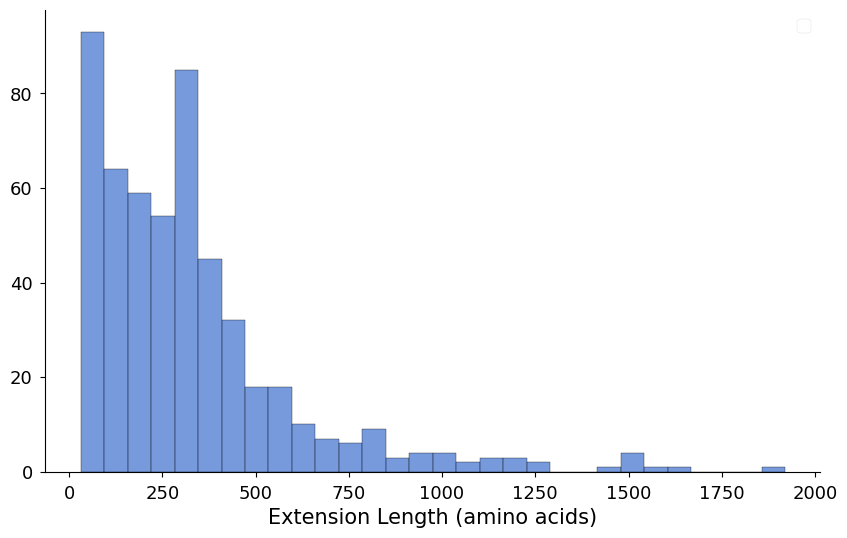

In [33]:
# 1. Distribution of extension lengths

# Set font sizes
label_fontsize = 15
tick_fontsize = 13
legend_fontsize = 13
title_fontsize = 20


plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='extension_length', bins=30)
plt.xlabel('Extension Length (amino acids)', fontsize=label_fontsize)
plt.ylabel('', fontsize=label_fontsize)
# plt.axvline(x=30, color='r', linestyle='--', label='Minimum threshold')
plt.legend(fontsize=legend_fontsize)
# set tick fontsize
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
sns.despine()
plt.savefig('../results/figures/extension_length_distribution.svg', dpi=300)

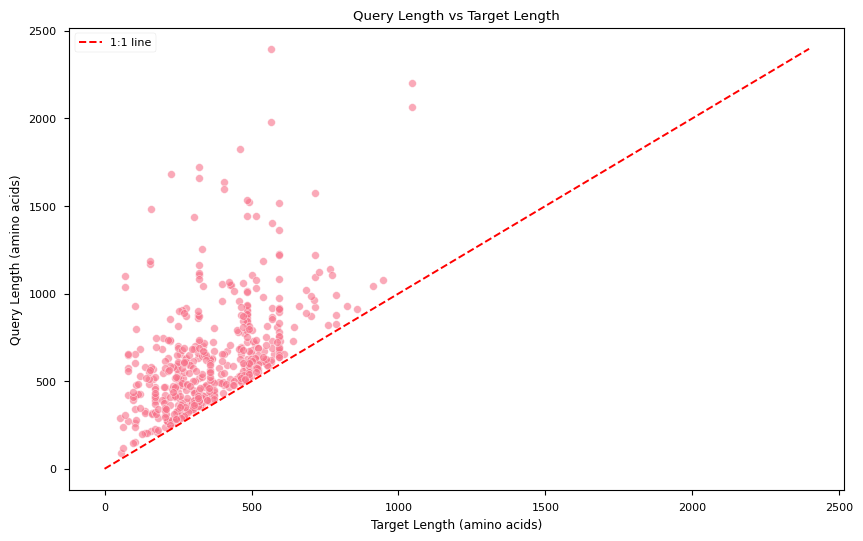

In [10]:
# 2. Scatter plot of query vs target lengths
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='target_length', y='qlen', alpha=0.6)
plt.plot([0, max(results_df['qlen'])], [0, max(results_df['qlen'])], 
         'r--', label='1:1 line')
plt.title('Query Length vs Target Length')
plt.xlabel('Target Length (amino acids)')
plt.ylabel('Query Length (amino acids)')
plt.legend()
plt.show()


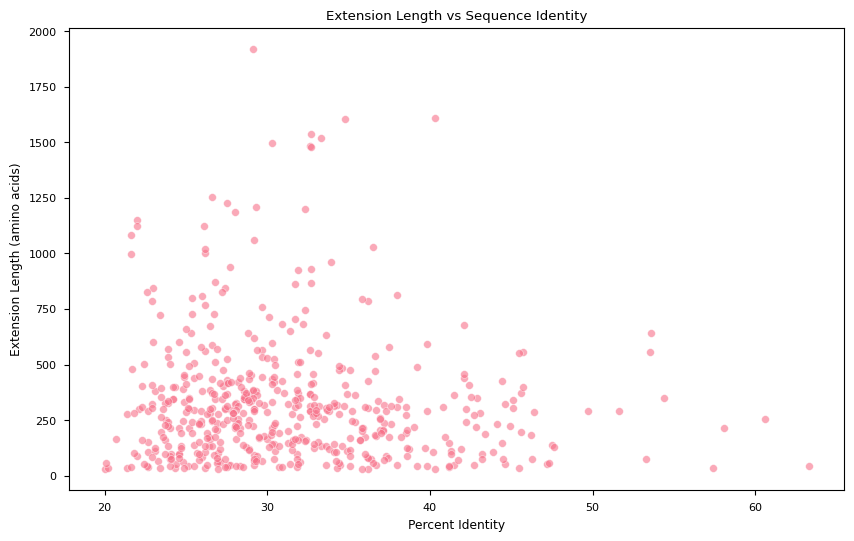

In [11]:
# 3. Relationship between extension length and sequence identity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='pident', y='extension_length', alpha=0.6)
plt.title('Extension Length vs Sequence Identity')
plt.xlabel('Percent Identity')
plt.ylabel('Extension Length (amino acids)')
plt.show()

In [12]:
# 4. Load sequences and analyze properties of extensions
def get_extension_properties(seq):
    """Calculate basic properties of a protein sequence"""
    try:
        analysis = ProteinAnalysis(str(seq))
        return {
            'length': len(seq),
            'molecular_weight': analysis.molecular_weight(),
            'aromaticity': analysis.aromaticity(),
            'instability_index': analysis.instability_index(),
            'gravy': analysis.gravy(),  # Hydropathy
            'charged_residues': (
                analysis.count_amino_acids()['R'] + 
                analysis.count_amino_acids()['K'] + 
                analysis.count_amino_acids()['D'] + 
                analysis.count_amino_acids()['E']
            ) / len(seq)
        }
    except:
        return None

# Load extensions and calculate properties
extensions_properties = []
with open("../results/c-terminal-extension/extensions.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        props = get_extension_properties(record.seq)
        if props:
            props['id'] = record.id
            extensions_properties.append(props)

ext_props_df = pd.DataFrame(extensions_properties)

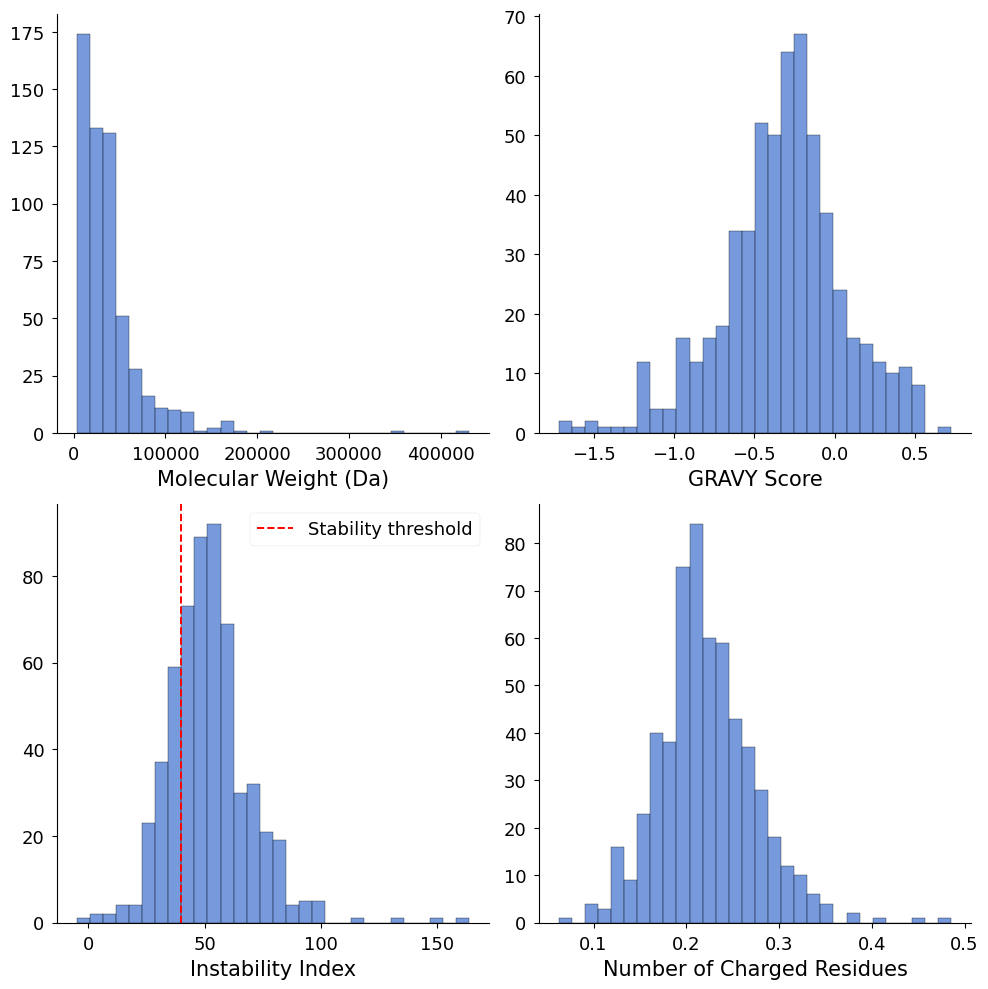

In [27]:

# 5. Plot extension properties
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Set font sizes
label_fontsize = 15
tick_fontsize = 13
legend_fontsize = 13
title_fontsize = 20

# Molecular weight distribution
sns.histplot(data=ext_props_df, x='molecular_weight', bins=30, ax=axes[0,0])
axes[0,0].set_xlabel('Molecular Weight (Da)', fontsize=label_fontsize)
axes[0,0].set_ylabel('', fontsize=label_fontsize)
axes[0,0].tick_params(axis='both', labelsize=tick_fontsize)
# axes[0,0].set_title('Molecular Weight Distribution', fontsize=title_fontsize)

# Hydropathy (GRAVY) distribution
sns.histplot(data=ext_props_df, x='gravy', bins=30, ax=axes[0,1])
axes[0,1].set_xlabel('GRAVY Score', fontsize=label_fontsize)
axes[0,1].set_ylabel('', fontsize=label_fontsize)
axes[0,1].tick_params(axis='both', labelsize=tick_fontsize)
# axes[0,1].set_title('Hydropathy (GRAVY) Distribution', fontsize=title_fontsize)

# Instability index
sns.histplot(data=ext_props_df, x='instability_index', bins=30, ax=axes[1,0])
axes[1,0].set_xlabel('Instability Index', fontsize=label_fontsize)
axes[1,0].set_ylabel('', fontsize=label_fontsize)
axes[1,0].tick_params(axis='both', labelsize=tick_fontsize)
# axes[1,0].set_title('Instability Index Distribution', fontsize=title_fontsize)
axes[1,0].axvline(x=40, color='r', linestyle='--', 
                  label='Stability threshold')
axes[1,0].legend(fontsize=legend_fontsize)

# Charged residues
sns.histplot(data=ext_props_df, x='charged_residues', bins=30, ax=axes[1,1])
axes[1,1].set_xlabel('Number of Charged Residues', fontsize=label_fontsize)
axes[1,1].set_ylabel('', fontsize=label_fontsize)
axes[1,1].tick_params(axis='both', labelsize=tick_fontsize)
# axes[1,1].set_title('Distribution of Charged Residues', fontsize=title_fontsize)

sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../results/figures/extension_properties.svg', dpi=300)

In [14]:
# 6. Summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print("\nExtension Lengths:")
print(results_df['extension_length'].describe())
print("\nSequence Identity:")
print(results_df['pident'].describe())
print("\nExtension Properties:")
print(ext_props_df[['molecular_weight', 'gravy', 
                    'instability_index', 'charged_residues']].describe())

# 7. Calculate and display proportions of stable vs unstable extensions
stable_proportion = (ext_props_df['instability_index'] < 40).mean() * 100
print(f"\nProportion of stable extensions: {stable_proportion:.1f}%")



Summary Statistics:
--------------------------------------------------

Extension Lengths:
count     529.000000
mean      324.211720
std       282.648614
min        31.000000
25%       132.000000
50%       278.000000
75%       404.000000
max      1920.000000
Name: extension_length, dtype: float64

Sequence Identity:
count    529.000000
mean      31.297353
std        6.954494
min       20.000000
25%       26.300000
50%       29.700000
75%       34.900000
max       63.300000
Name: pident, dtype: float64

Extension Properties:
       molecular_weight       gravy  instability_index  charged_residues
count        575.000000  575.000000         575.000000        575.000000
mean       37371.013491   -0.322427          52.034935          0.221957
std        37541.891869    0.381860          17.724224          0.051641
min         3242.529600   -1.716418          -5.080000          0.062500
25%        14593.830250   -0.513726          41.029957          0.191174
50%        29866.643400   -0.29